# Fleet Predictive Maintenance: Part 3. Feature Engineering

## Data Preparation: Featurization and Exploratory Data Visualization

*Using SageMaker Studio to Predict Fault Classification*

1. [Architecure](0_usecase_and_architecture_predmaint.ipynb#0_Architecture)
1. [Data Prep: Processing Job from Data Wrangler Output](./1_dataprep_dw_job_predmaint.ipynb)
1. [Data Prep: Featurization](./2_dataprep_predmaint.ipynb)
1. [Train, Tune and Predict using Batch Transform](./3_train_tune_predict_predmaint.ipynb)

---
<a id ='2_Contents' > </a>

## Contents

1. [Background](#Background)
1. [Setup](#2_Setup)
1. [Data](#2_Data)
1. [Feature Engineering](#2_Features)
1. [Data Visualization](#2_Visualization)


---

## Background

The purpose of this notebook is to demonstrate a Predictive Maintenance (PrM) solution for automible fleet maintenance via Amazon SageMaker Studio so that business users have a quick path towards a PrM POC. In this notebook, we focus on preprocessing engine sensor data before feature engineering and buidling an inital model leveraging SageMaker's algorithms. This notebook will cover the following:

* Setup for using SageMaker
* Basic data cleaning, analysis and preprocessing
* Converting datasets to format used by the Amazon SageMaker algorithms and uploading to S3 
* Training SageMaker's linear learner on the dataset
* Hyperparamter tuning using SageMaker Automatic Tuning
* Deploying and getting predictions using Batch Transform

## Important Notes: 

* Due to cost consideration, the goal of this example is to show you how to use some of SageMaker Studio's features, not necessarily to achieve the best result. 
* We use the built-in classification algorithm in this example, and a Python 3 (Data Science) Kernel is required.
* The nature of predictive maintenace solutions, requires a domain knowledge expert of the system or machinery. With this in mind, we will make assumptions here for certain elements of this solution with the acknowldgement that these assumptions should be informed by a domain expert and a main business stakeholder

Please see the README.md for more information about this use case. 

---
<a id='2_Setup' > </a>
## Set up

[contents](#2_Contents)

Let's start by:

* Setting up or refreshing storemagic variables 
* Install and Import any dependencies
* Instatiate SageMaker session
* Specifying the S3 bucket and prefix that you want to use for your training and model data. This should be within the same region as SageMaker training
* Define the IAM role used to give training access to your data
 

### View stored variables from previous session
If you ran this notebook before, you may want to re-use the resources you aready created with AWS. Run the cell below to load any prevously created variables. You should see a print-out of the existing variables. If you don't see anything you may need to create them again or it may be your first time running this notebook.

In [ ]:
%store -r
%store

Note : <font color=red> dw_output_path_prm </font> should appear above as a stored (restored) variable, whose value was set when you ran notebook 1_datapred_predmaint.ipynb

In [6]:
# Install any missing dependencies
!pip install -qU 'sagemaker-experiments==0.1.24' 'sagemaker>=2.16.1' 'boto3' 'awswrangler'

In [7]:
import os
import json
import sys
import collections
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SageMaker dependencies
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
import awswrangler as wr

# This instantiates a SageMaker session that we will be operating in.
smclient = boto3.Session().client("sagemaker")
region = boto3.Session().region_name

# This object represents the IAM role that we are assigned.
role = sagemaker.get_execution_role()

sess = sagemaker.Session()
bucket = sess.default_bucket()

# prefix is the path within the bucket where SageMaker stores the output from training jobs.
prefix_prm = "predmaint"  # place to upload training files within the bucket

---
<a id = '2_Data'> </a>
## Data

#### Load, preparation, EDA and Preprocessing 

[contents](#2_Contents)

For the initial data preparation and exploration, we will utilize SageMaker's new feature, Data Wrangler, to load data and do some data transformations. In the Data Wrangler GUI, we will perform the following steps. Note that because this data is generated, the data is relatively clean and there are few data cleaning steps needed. 
1. Load fleet sensor logs data from S3
1. Load fleet details data from S3
1. Change column data types 
1. Change coulmn headers 
1. Check for Null/NA values (impute or drop)
1. Join sensor and details data
1. One-Hot Encode categorical features
1. Do preliminar analysis using built-in feature
1. Export recipe as SageMaker Data Wrangler job
1. Upload final cleaned data set to S3



For our purposes, we will download the final clened data set from S3 into our SageMaker Studio instance, but for more information on how to load and preprocess tabular data follow this link: [Tabular Preprocessing Blog]().
For additional information on preprocessing for PrM, please refer to this blog, [On the relevance of preprocessing in predictive
maintenance for dynamic systems](https://bird.bcamath.org/bitstream/handle/20.500.11824/892/CernudaPREDICT2018S16.pdf?sequence=1&isAllowed=y).

In [8]:
fleet = wr.s3.read_csv(path=dw_output_path_prm, dataset=True)

In [9]:
# add in additional features and change data types
fleet["datetime"] = pd.to_datetime(fleet["datetime"], format="%Y-%m-%d %H:%M:%S")
fleet["cycle"] = fleet.groupby("vehicle_id")["datetime"].rank("dense")
fleet["make"] = fleet["make"].astype("category")
fleet["model"] = fleet["model"].astype("category")
fleet["vehicle_class"] = fleet["vehicle_class"].astype("category")
fleet["engine_type"] = fleet["engine_type"].astype("category")
fleet["engine_age"] = fleet["datetime"].dt.year - fleet["year"]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [10]:
fleet = fleet[
    [
        "target",
        "vehicle_id",
        "datetime",
        "make",
        "model",
        "year",
        "vehicle_class",
        "engine_type",
        "make_code_Make A",
        "make_code_Make B",
        "make_code_Make E",
        "make_code_Make C",
        "make_code_Make D",
        "model_code_Model E1",
        "model_code_Model A4",
        "model_code_Model B1",
        "model_code_Model B2",
        "model_code_Model A2",
        "model_code_Model A3",
        "model_code_Model B3",
        "model_code_Model C2",
        "model_code_Model A1",
        "model_code_Model A5",
        "model_code_Model A6",
        "model_code_Model C1",
        "model_code_Model D1",
        "model_code_Model E2",
        "vehicle_class_code_Truck-Tractor",
        "vehicle_class_code_Truck",
        "vehicle_class_code_Bus",
        "vehicle_class_code_Transport",
        "engine_type_code_Engine E",
        "engine_type_code_Engine C",
        "engine_type_code_Engine B",
        "engine_type_code_Engine F",
        "engine_type_code_Engine H",
        "engine_type_code_Engine D",
        "engine_type_code_Engine A",
        "engine_type_code_Engine G",
        "voltage",
        "current",
        "resistance",
        "cycle",
        "engine_age",
    ]
]

In [11]:
fleet.sort_values(by=["vehicle_id", "datetime"], inplace=True)
fleet.to_csv("fleet_data.csv", index=False)
fleet.shape

(9000, 44)

#### Key observations:

- There are 90 vehicles in the fleet
- Data has 9000 observations and 44 columns.
- Vehicle can be identified useing the 'vehicle_id' column.
- The label column, called 'Target', is an indicator of failure ('0' = No Failure; '1' = Failure).
- There are 4 numeric features available for prediction and 4 categorical features. We will expand upon these later in the Feature Engineering section of this notebook. 

In [12]:
# # run this cell to pick-up the new cleaned dataset
# fleet = pd.read_csv('fleet_data.csv')

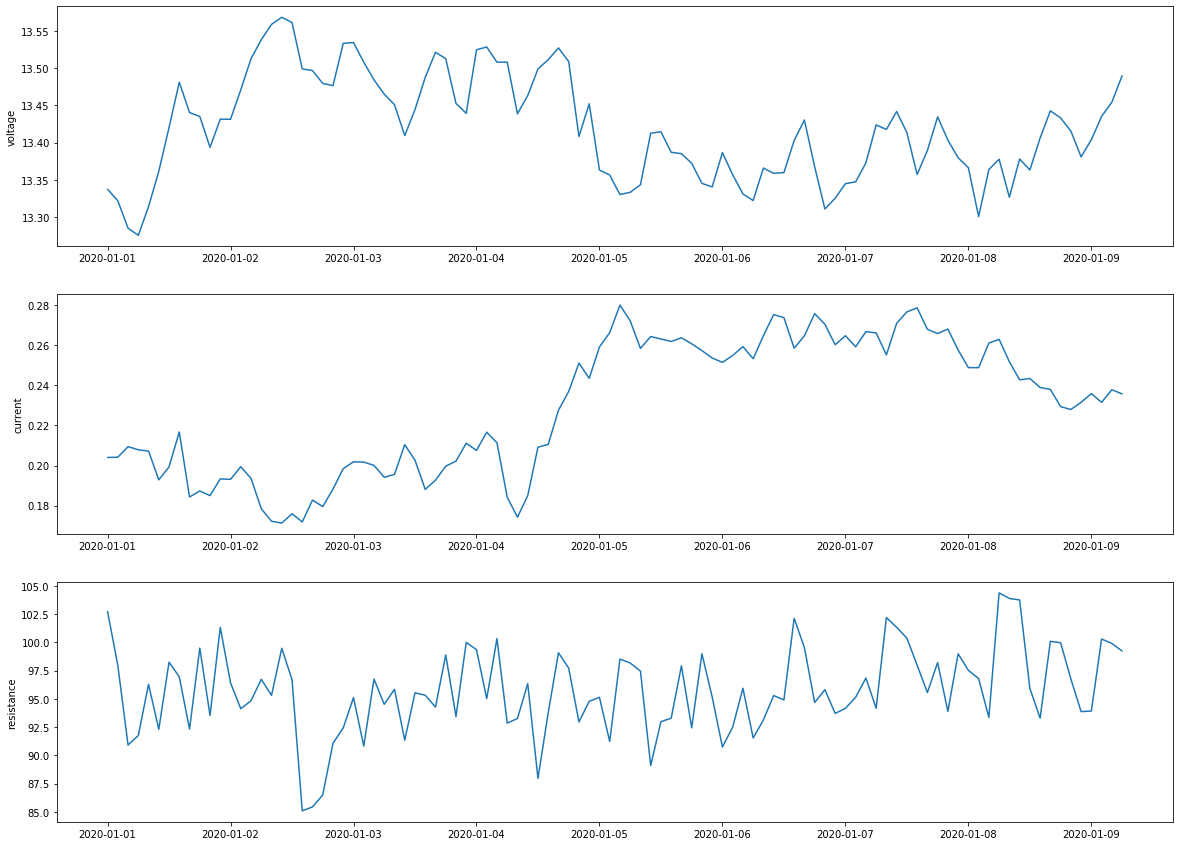

In [13]:
%matplotlib inline
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
plot_fleet = fleet.loc[fleet["vehicle_id"] == 1]

sns.set_style("darkgrid")
axs[0].plot(plot_fleet["datetime"], plot_fleet["voltage"])
axs[1].plot(plot_fleet["datetime"], plot_fleet["current"])
axs[2].plot(plot_fleet["datetime"], plot_fleet["resistance"])

axs[0].set_ylabel("voltage")
axs[1].set_ylabel("current")
axs[2].set_ylabel("resistance");

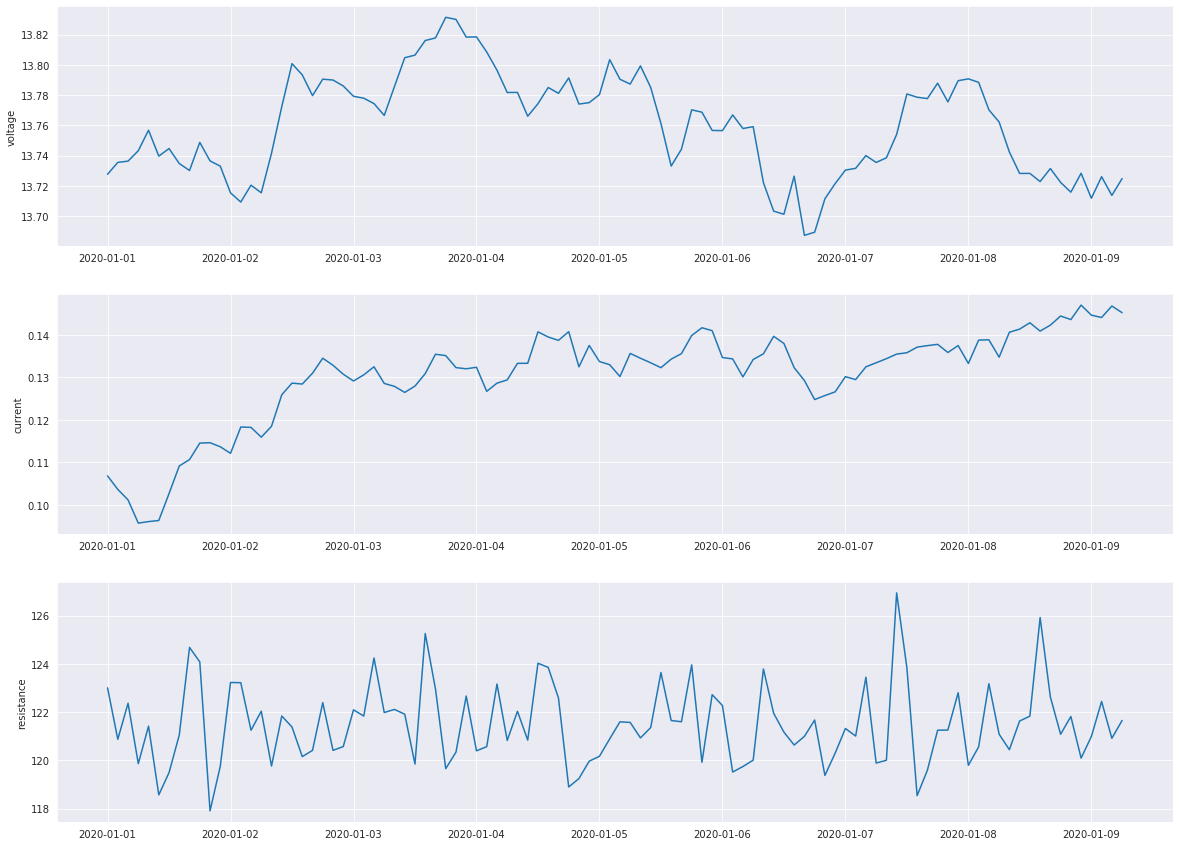

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
plot_fleet = fleet.loc[fleet["vehicle_id"] == 2]

sns.set_style("darkgrid")
axs[0].plot(plot_fleet["datetime"], plot_fleet["voltage"])
axs[1].plot(plot_fleet["datetime"], plot_fleet["current"])
axs[2].plot(plot_fleet["datetime"], plot_fleet["resistance"])

axs[0].set_ylabel("voltage")
axs[1].set_ylabel("current")
axs[2].set_ylabel("resistance");

In [15]:
# let's look at the proportion of failures to non-failure
print(fleet["target"].value_counts())
print(
    "\nPercent of failures in the dataset: "
    + str(fleet["target"].value_counts()[1] / len(fleet["target"]))
)
print(
    "Number of vehicles with 1+ failures: "
    + str(fleet[fleet["target"] == 1]["vehicle_id"].drop_duplicates().count())
    + "\n"
)

# view the percentage distribution of target column
print(fleet["target"].value_counts() / np.float(len(fleet)))

0    7238
1    1762
Name: target, dtype: int64

Percent of failures in the dataset: 0.19577777777777777
Number of vehicles with 1+ failures: 49

0    0.804222
1    0.195778
Name: target, dtype: float64


We can see that percentage of observations of the class label 0 (no failure) and 1 (failure) is 80.42% and 19.58% respectively. So, this is a class imbalanced problem. For PrM, class imbalance is oftentimes a problem as failues happen less frequently and businesses do not want to allow for more failures than is necessary. There are a variety of techniques for dealing with class imbalances in data such as [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html). For this use case, we will leverage SageMaker's Estimator built-in hyperparameters to I will deal with imbalance. We discuss more in a later section.

In [16]:
p = fleet.groupby(["vehicle_id"])["target"].sum().rename("percentage of failures")
fail_percent = pd.DataFrame(p / 100)
print(fail_percent.sort_values("percentage of failures", ascending=False).head(20))
# fail_percent.plot(kind='box')

            percentage of failures
vehicle_id                        
84                            1.00
65                            1.00
17                            1.00
71                            1.00
28                            0.99
15                            0.92
3                             0.88
63                            0.76
31                            0.74
40                            0.73
75                            0.67
6                             0.66
73                            0.61
42                            0.58
64                            0.49
85                            0.42
16                            0.40
22                            0.38
39                            0.36
26                            0.35


In [17]:
# check for missing values
print(fleet.isnull().sum())

# check sensor readings for zeros
fleet[fleet.loc[:, "voltage":"resistance"].values == 0]

target                              0
vehicle_id                          0
datetime                            0
make                                0
model                               0
year                                0
vehicle_class                       0
engine_type                         0
make_code_Make A                    0
make_code_Make B                    0
make_code_Make E                    0
make_code_Make C                    0
make_code_Make D                    0
model_code_Model E1                 0
model_code_Model A4                 0
model_code_Model B1                 0
model_code_Model B2                 0
model_code_Model A2                 0
model_code_Model A3                 0
model_code_Model B3                 0
model_code_Model C2                 0
model_code_Model A1                 0
model_code_Model A5                 0
model_code_Model A6                 0
model_code_Model C1                 0
model_code_Model D1                 0
model_code_M

,target,vehicle_id,datetime,make,model,year,vehicle_class,engine_type,make_code_Make A,make_code_Make B,...,engine_type_code_Engine F,engine_type_code_Engine H,engine_type_code_Engine D,engine_type_code_Engine A,engine_type_code_Engine G,voltage,current,resistance,cycle,engine_age


---
<a id="2_Features"> </a>
## Feature Engineering 


[contents](#2_Contents)

For PrM, feature selection, generation and engineering is extremely important and very depended on domain expertise and understanding of the systems involved. For our solution, we will focus on the some simple features such as:
* lag features 
* rolling average
* rolling standard deviation 
* age of the engines 
* categorical labels

These features serve as a small example of the potential features that could be created. Other features to consider are changes in the sensor values within a window, change from the initial value or number over a defined threshold. For additional guidance on Feature Engineering, visit the [SageMaker Tabular Feature Engineering guide](). 

In [18]:
# # optional: load in the fleet dataset from above
# fleet = pd.read_csv('fleet_data.csv')
fleet.datetime = pd.to_datetime(fleet.datetime)

In [19]:
# add lag features for voltage, current and resistance
# we will only look as 2 lags
for i in range(1, 2):
    fleet["voltage_lag_" + str(i)] = (
        fleet.groupby("vehicle_id")["voltage"].shift(i).fillna(method="bfill", limit=7)
    )
    fleet["current_lag_" + str(i)] = (
        fleet.groupby("vehicle_id")["current"].shift(i).fillna(method="bfill", limit=7)
    )
    fleet["resistance_lag_" + str(i)] = (
        fleet.groupby("vehicle_id")["resistance"].shift(i).fillna(method="bfill", limit=7)
    )

In [20]:
# create rolling stats for voltage, current and resistance group by vehicle_id
stats = pd.DataFrame()
grouped = fleet.groupby("vehicle_id")

# windows set to 4
# you could also add in additional rolling window lengths based on the machinery and domain knowledge
mean = [
    (col + "_" + "rolling_mean_" + str(win), grouped[col].rolling(window=win).mean())
    for win in [4]
    for col in ["voltage", "current", "resistance"]
]
std = [
    (col + "_" + "rolling_std_" + str(win), grouped[col].rolling(window=win).std())
    for win in [4]
    for col in ["voltage", "current", "resistance"]
]
df_mean = pd.DataFrame.from_dict(collections.OrderedDict(mean))
df_std = pd.DataFrame.from_dict(collections.OrderedDict(std))
stats = (
    pd.concat([df_mean, df_std], axis=1)
    .reset_index()
    .set_index("level_1")
    .fillna(method="bfill", limit=7)
)  # fill backward
stats.head(5)

,vehicle_id,voltage_rolling_mean_4,current_rolling_mean_4,resistance_rolling_mean_4,voltage_rolling_std_4,current_rolling_std_4,resistance_rolling_std_4
level_1,,,,,,,
0,0,14.034030,0.173326,128.312760,0.054298,0.004201,4.661643
1,0,14.034030,0.173326,128.312760,0.054298,0.004201,4.661643
2,0,14.034030,0.173326,128.312760,0.054298,0.004201,4.661643
3,0,14.034030,0.173326,128.312760,0.054298,0.004201,4.661643
4,0,14.011934,0.172462,121.848069,0.028505,0.003398,10.347376


In [21]:
fleet_lagged = pd.concat([fleet, stats.drop(columns=["vehicle_id"])], axis=1)
fleet_lagged.head(2)

,target,vehicle_id,datetime,make,model,year,vehicle_class,engine_type,make_code_Make A,make_code_Make B,...,engine_age,voltage_lag_1,current_lag_1,resistance_lag_1,voltage_rolling_mean_4,current_rolling_mean_4,resistance_rolling_mean_4,voltage_rolling_std_4,current_rolling_std_4,resistance_rolling_std_4
0,0,0,2020-01-01 00:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,2,14.103421,0.177269,133.059603,14.03403,0.173326,128.31276,0.054298,0.004201,4.661643
1,0,0,2020-01-01 02:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,2,14.103421,0.177269,133.059603,14.03403,0.173326,128.31276,0.054298,0.004201,4.661643


In [22]:
# let's look at the descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution
round(fleet_lagged.describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
target,9000.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
vehicle_id,9000.0,44.50,25.98,0.00,22.00,44.50,67.00,89.00
year,9000.0,2016.07,3.06,2006.00,2015.00,2017.00,2018.00,2020.00
make_code_Make A,9000.0,0.40,0.49,0.00,0.00,0.00,1.00,1.00
make_code_Make B,9000.0,0.24,0.43,0.00,0.00,0.00,0.00,1.00
make_code_Make E,9000.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
make_code_Make C,9000.0,0.11,0.31,0.00,0.00,0.00,0.00,1.00
make_code_Make D,9000.0,0.04,0.21,0.00,0.00,0.00,0.00,1.00
model_code_Model E1,9000.0,0.18,0.38,0.00,0.00,0.00,0.00,1.00
model_code_Model A4,9000.0,0.13,0.34,0.00,0.00,0.00,0.00,1.00


---
<a id='2_Visualization'> </a>
## Visualization of the Data Distributions

[contents](#2_Contents)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


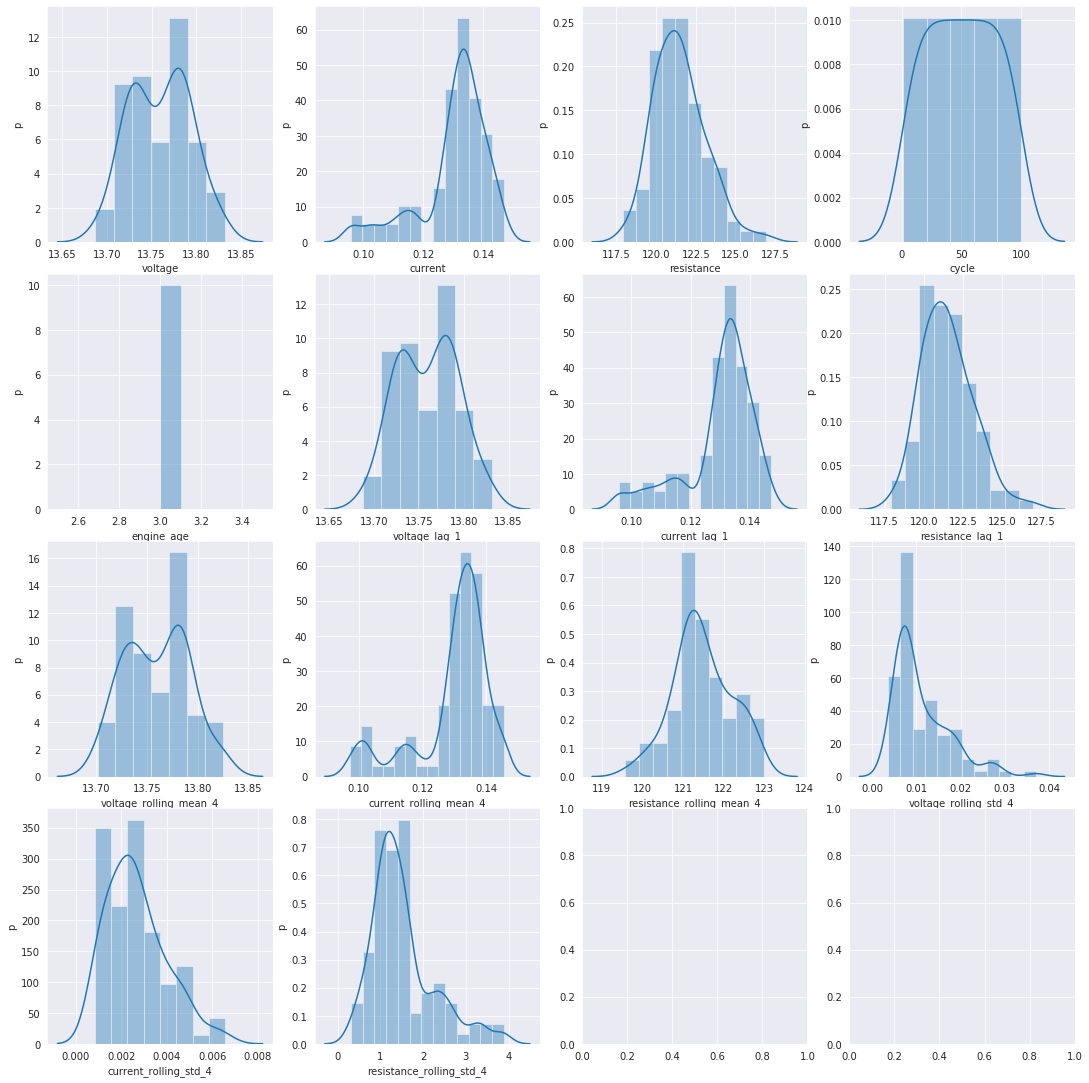

In [23]:
# plot a single engine's histograms
# we will lood at vehicle_id 2 as it has 1+ failures
def plot_engine_hists(sensor_data):
    cols = sensor_data.columns
    n_cols = min(len(cols), 4)
    n_rows = int(np.ceil(len(cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    plt.tight_layout()
    axes = axes.flatten()
    for col, ax in zip(cols, axes):
        sns.distplot(sensor_data[[col]], ax=ax, label=col)
        ax.set_xlabel(col)
        ax.set_ylabel("p")


plot_engine_hists(fleet_lagged[fleet_lagged["vehicle_id"] == 2].loc[:, "voltage":])

In [24]:
# remove features used for one-hot encoding the categorical features including make, model, engine_type and vehicle_class
features = fleet_lagged.drop(columns=["make", "model", "year", "vehicle_class", "engine_type"])
features.to_csv("features.csv", index=False)
features_created_prm = True
%store features_created_prm

Stored 'features_created_prm' (bool)


In [25]:
features = pd.read_csv("features.csv")

Although we have kept the EDA and feature engineering limited here, there is much more that could be done. Additional analysis could be done to understand if the relationships between the make and model and/or the engine type and failure rates. Also, much more analysis could be done based on discussions with domain experts and their in-depth understandings of the systems based on experience.   

#### Now let's split our data into train, test and validation

For PrM, we will want to split the data based on a time-dependent record splitting strategy since the data is time series sensor readings. We will make the splits by choosing a points in time based on the desired size of the training, test and validations sets. To prevent any records in the training set from sharing time windows with the records in the test set, we remove any records at the boundary.

In [ ]:
# we will devote 80% to training, and we will save 10% for test and ~10% for validation (less the dropped records to avoid data leakage)
train_size = int(len(features) * 0.80)
val_size = int(len(features) * 0.10)

# order by datetime in order to split on time
ordered = features.sort_values("datetime")

# make train, test and validation splits
train, test, val = (
    ordered[0:train_size],
    ordered[train_size : train_size + val_size],
    ordered.tail(val_size),
)
train.sort_values(["vehicle_id", "datetime"], inplace=True)

# make sure there is no data leakage between train, test and validation
test = test.loc[test["datetime"] > train["datetime"].max()]
val = val.loc[val["datetime"] > test["datetime"].max()]

print("First train datetime: ", train["datetime"].min())
print("Last train datetime: ", train["datetime"].max(), "\n")
print("First test datetime: ", test["datetime"].min())
print("Last test datetime: ", test["datetime"].max(), "\n")
print("First validation datetime: ", val["datetime"].min())
print("Last validation datetime: ", val["datetime"].max())

In [27]:
train = train.drop(["datetime", "vehicle_id"], axis=1)

test = test.sort_values(["vehicle_id", "datetime"])
test = test.drop(["datetime", "vehicle_id"], axis=1)

val = val.sort_values(["vehicle_id", "datetime"])
val = val.drop(["datetime", "vehicle_id"], axis=1)

In [28]:
print("Total Observations: ", len(ordered))
print("Number of observations in the training data:", len(train))
print("Number of observations in the test data:", len(test))
print("Number of observations in the validation data:", len(val))

Total Observations:  9000
Number of observations in the training data: 7200
Number of observations in the test data: 900
Number of observations in the validation data: 900


#### Converting data to the appropriate format for Estimator

Amazon SageMaker implementation of Linear Learner takes either csv format or recordIO-wrapped protobuf. We will start by scaling the features and saving the data files to csv format. Then, we will upload the data to S3. If you are using your own data, and it is too large to fit in memory, protobuf might be a better option than csv. Refer to the SageMaker's Developer's Guide for [more information on data formats for training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).

In [29]:
# scale all features for train, test and validation
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
train = pd.DataFrame(scaler.fit_transform(train))
test = pd.DataFrame(scaler.transform(test))
val = pd.DataFrame(scaler.transform(val))

Add in a helper function that uploads the converted data to S3. 

In [30]:
# helper function for converting data to csv(necessary for Linear Learner) and upload to S3
def upload_file_to_bucket(df, bucket, prefix, file_path):
    file_dir, file_name = os.path.split(file_path)
    df.to_csv(file_name, header=False, index=False)
    boto3.resource("s3").meta.client.upload_file(
        Filename=file_path, Bucket=bucket, Key=(prefix + "/" + file_name)
    )
    print(f"uploaded {prefix} data location: s3://{bucket}/{prefix}/{file_name}")
    path_to_data = f"s3://{bucket}/{prefix}/{file_name}"
    return path_to_data

In [ ]:
# convert and upload to S3
path_to_train_data_prm = upload_file_to_bucket(train, bucket, "train", "train.csv")
path_to_test_data_prm = upload_file_to_bucket(test, bucket, "test", "test.csv")
path_to_test_x_data_prm = upload_file_to_bucket(test.loc[:, 1:], bucket, "test", "test_x.csv")
path_to_valid_data_prm = upload_file_to_bucket(val, bucket, "validation", "validation.csv")

# let's also setup an output S3 location for the model artifact that will be output as the result of training with the algorithm.
output_location = f"s3://{bucket}/output"
print("training artifacts will be uploaded to: {}".format(output_location))

%store path_to_train_data_prm
%store path_to_test_data_prm
%store path_to_test_x_data_prm
%store path_to_valid_data_prm

In [32]:
from sagemaker.inputs import TrainingInput

train_channel = TrainingInput(path_to_train_data_prm, content_type="text/csv")
test_channel = TrainingInput(path_to_test_data_prm, content_type="text/csv")
test_x_channel = TrainingInput(path_to_test_x_data_prm, content_type="text/csv")
valid_channel = TrainingInput(path_to_valid_data_prm, content_type="text/csv")

data_channels = {"train": train_channel, "validation": valid_channel}
%store data_channels

Stored 'data_channels' (dict)


At this point, the data has been cleaned, preprocessed and features have been created. We have also stored the data in S3, so you are able to pick the notebook up starting from the *Train* section below without running the above again. 

---
## Next Notebook : Train

### SageMaker Estimator and Experiments

Once you have selected some models that you would like to try out, SageMaker Experiments can be a great tool to track and compare all of the models before selecting the best model to deploy. We will set up an experiment using SageMaker experiments to track all the model training iterations for the Linear Learner Estimator we will try. You can read more about [SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) to learn about experiment features, tracking and comparing outputs.   